In [1]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
valDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
valLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
testDataFile = 'ijcnlp_dailydialog/test/dialogues_test.txt'
testLablesFile = 'ijcnlp_dailydialog/test/dialogues_act_test.txt'

In [5]:
lineSeparator = '__eou__'

In [6]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        
        label = np.array(list(map(int, label))) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [7]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
valX_all, valX_data, valY_all, valY = getData(valDataFile, valLablesFile)
testX_all, testX_data, testY_all, testY = getData(testDataFile, testLablesFile)

In [8]:
train_dialogues = len(trainX_all)
val_dialogues = len(valX_all)
test_dialogues = len(testX_all)
fullData_temp = trainX_all + valX_all + testX_all

In [9]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
embed_path = '/home/abhishekjindal/nlp/data/glove.840B.300d.txt'

In [10]:
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

torch.nn.Module.dump_patches = True

In [11]:
# sentEmbedModel = torch.load('encoder/infersent.allnli.pickle', map_location=lambda storage, loc: storage)

sentEmbedModel = torch.load('encoder/infersent.allnli.pickle')
sentEmbedModel = sentEmbedModel.cuda()

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. Saved a reverse patch to BLSTMEncoder.patch. Run `patch -p0 < BLSTMEncoder.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


In [12]:
sentEmbedModel.is_cuda()

True

In [13]:
sentEmbedModel.set_glove_path(embed_path)

In [14]:
%%time
sentEmbedModel.build_vocab(fullData_temp, tokenize=True)
#sentEmbedModel.build_vocab_k_words(K=100000)

Found 23332(/26376) words with glove vectors
Vocab size : 23332
CPU times: user 28.4 s, sys: 1.64 s, total: 30.1 s
Wall time: 30 s


In [15]:
%%time
final_emb = sentEmbedModel.encode(fullData_temp, bsize=128, tokenize=False, verbose=False)
#final_emb = sentEmbedModel.encode(fullData_temp, tokenize=True)

CPU times: user 42.5 s, sys: 22.9 s, total: 1min 5s
Wall time: 1min 5s


In [16]:
final_emb.shape

(102979, 4096)

In [17]:
curr_count = 0
train_emb_data = final_emb[curr_count:(curr_count+train_dialogues)]
curr_count += train_dialogues
val_emb_data = final_emb[curr_count:(curr_count+val_dialogues)]
curr_count += val_dialogues
test_emb_data = final_emb[curr_count:(curr_count+test_dialogues)]
print(curr_count+test_dialogues)

102979


# Train a classifier

In [18]:
# Parameters used.
MODEL_PATH = './model_crf_v7.ckpt'

In [19]:
learning_rate = 0.03
#training_epochs = 7
input_size = 4096 #sent_embed_size
#batch_size = 25
#num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all)) + 2
start_label = len(set(trainY_all))
end_label = start_label + 1
start_emb = np.random.choice([-1, 1], size=(1,input_size), p=[110./111, 1./111])
end_emb = np.random.choice([-1, 1], size=(1,input_size), p=[1./111, 110./111])

In [20]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [21]:
def create_embedding_conversation_data(complete_emb, seq_len, start_emb, end_emb):
    curr_count = 0;
    final_data = [];
    #print(complete_emb[0:2])
    for i in range(len(seq_len)):
        
        emb_temp = complete_emb[curr_count:(curr_count+seq_len[i])]
        emb_temp = np.concatenate((start_emb, emb_temp))
        emb_temp = np.concatenate((emb_temp, end_emb))
        final_data.append(emb_temp)
        curr_count += seq_len[i]
    return final_data

In [22]:
def adding_start_end_labels(labels, start_label, end_label):
    final_lab = [];
    for i in range(len(labels)):
        temp = labels[i]
        temp = np.concatenate((np.array([start_label]), temp))
        temp = np.concatenate((temp, np.array([end_label])))
        final_lab.append(temp)
    
    return final_lab

In [23]:

sequence_length_train = np.array(get_sequence_length(trainX_data))
sequence_length_val = np.array(get_sequence_length(valX_data))
sequence_length_test = np.array(get_sequence_length(testX_data))

x_train = create_embedding_conversation_data(train_emb_data, sequence_length_train, start_emb, end_emb)
x_val = create_embedding_conversation_data(val_emb_data, sequence_length_val, start_emb, end_emb)
x_test = create_embedding_conversation_data(test_emb_data, sequence_length_test, start_emb, end_emb)

# For start end indices
sequence_length_train += 2 
sequence_length_val += 2
sequence_length_test += 2


y_train = adding_start_end_labels(trainY, start_label, end_label)
y_val = adding_start_end_labels(valY, start_label, end_label)
y_test = adding_start_end_labels(testY, start_label, end_label)


In [24]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    return np.concatenate((sentence, padding))

In [25]:
input_data = tf.placeholder(tf.float32, [None, None, input_size], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [26]:
weights = tf.get_variable("weights", [input_size, number_of_classes])
matricized_x_train = tf.reshape(input_data, [-1, input_size])
matricized_unary_scores = tf.matmul(matricized_x_train, weights)
#matricized_unary_scores = tf.sigmoid(matricized_unary_scores_temp)
scores = tf.reshape(matricized_unary_scores, [-1, batch_sequence_length, number_of_classes])
#scores = tf.reshape(matricized_unary_scores, [num_examples, num_words, num_tags])


In [27]:
# Linear-CRF.
temp_params = np.loadtxt('estimated_transition_params_crf.csv', delimiter=',')
#temp_params = np.log(temp_params)
temp_params = np.float32(temp_params)
trans_params = tf.get_variable("transitions", initializer = temp_params, trainable = True)
#transition_params = tf.get_variable("transitions", shape = [number_of_classes, number_of_classes]);
log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(scores, labels, original_sequence_lengths, trans_params)

loss = tf.reduce_mean(-log_likelihood)

# Compute the viterbi sequence and score (used for prediction and test time).
viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(scores, transition_params, original_sequence_lengths)

# Training ops.
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
def pad_data(sentence, max_length, input_size):
#     sent_emb = np.array([create_sentence_embed(x, word_emb, embed_size, unknown_token, pad_token, calc_mean = True) for x in sentence])
    #sent_emb = np.array([create_sentence_embed_facebook(x) for x in sentence])
    pad_len = max_length - len(sentence)
    temp = sentence
    if pad_len > 0:
        single_pad = np.zeros(input_size)
        padding = [single_pad] * pad_len
#         print(pad_len)
#         print(len(sent_emb), len(padding))
#         print(type(sent_emb), type(padding))
#         print(sent_emb.shape)
        #sent_emb = sent_emb.squeeze()
        temp = np.concatenate((temp, padding))
    return temp

In [29]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
#         print(_)
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
#         print(batch_sequence_lengths)
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
#         print(batch_length)
#         for x in data[index: index + batch_size]:
#             xx = pad_data(x, batch_length, input_size)
#             print(xx.shape)
        batch_data = np.array([pad_data(x, batch_length, input_size).squeeze() for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [30]:
%%time 
training_epochs = 12;
batch_size = 700;
#cnt = 0;
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            #cnt += 1
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
#             if (cnt*batch_size) % 10000 ==0:
    # Save the variables to disk.
        
        print("Saving model")
        saver.save(session, MODEL_PATH)

Epoch: 0 Accuracy: 0.05%
Epoch: 0 Accuracy: 22.19%
Epoch: 0 Accuracy: 18.53%
Epoch: 0 Accuracy: 27.02%
Epoch: 0 Accuracy: 31.85%
Epoch: 0 Accuracy: 36.64%
Epoch: 0 Accuracy: 44.01%
Epoch: 0 Accuracy: 43.20%
Epoch: 0 Accuracy: 52.49%
Epoch: 0 Accuracy: 56.77%
Epoch: 0 Accuracy: 61.53%
Epoch: 0 Accuracy: 60.29%
Epoch: 0 Accuracy: 60.07%
Epoch: 0 Accuracy: 60.72%
Epoch: 0 Accuracy: 64.47%
Epoch: 0 Accuracy: 67.19%
Saving model
Epoch: 1 Accuracy: 80.83%
Epoch: 1 Accuracy: 79.77%
Epoch: 1 Accuracy: 80.40%
Epoch: 1 Accuracy: 77.73%
Epoch: 1 Accuracy: 78.84%
Epoch: 1 Accuracy: 77.49%
Epoch: 1 Accuracy: 73.29%
Epoch: 1 Accuracy: 63.03%
Epoch: 1 Accuracy: 59.38%
Epoch: 1 Accuracy: 54.28%
Epoch: 1 Accuracy: 54.31%
Epoch: 1 Accuracy: 58.27%
Epoch: 1 Accuracy: 65.61%
Epoch: 1 Accuracy: 69.85%
Epoch: 1 Accuracy: 70.79%
Epoch: 1 Accuracy: 71.91%
Saving model
Epoch: 2 Accuracy: 84.58%
Epoch: 2 Accuracy: 83.92%
Epoch: 2 Accuracy: 85.01%
Epoch: 2 Accuracy: 82.48%
Epoch: 2 Accuracy: 84.13%
Epoch: 2 Accu

In [31]:
%%time
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_val, y_val, sequence_length_val, len(x_val), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    v = session.run(transition_params)
    np.savetxt('transition_params_crf_v7.csv', v, delimiter=',')
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    #print("Test accuracy: %.2f%%" % accuracy)
    print('This accuracy includes start end, so it is wrong!')

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v7.ckpt
This accuracy includes start end, so it is wrong!
Label: [4 1 0 2 1 0 1 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred.: [4 1 1 2 1 0 1 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
CPU times: user 876 ms, sys: 1.28 s, total: 2.16 s
Wall time: 2.05 s


# Evaluation

In [32]:
from sklearn import metrics

In [33]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][1:sequence_length_val[i]-1])

In [34]:
# Replacing all start and end predictions by 0
preds = [x if x < 4 else 0 for x in preds]


In [35]:
metrics.accuracy_score(valY_all, preds)

0.7489156029247738

In [36]:
import collections
counter=collections.Counter(preds)
print(counter)

Counter({0: 3317, 1: 2340, 2: 1604, 3: 808})


In [37]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.76      0.80      0.78      3125
          1       0.88      0.91      0.90      2244
          2       0.63      0.57      0.60      1775
          3       0.57      0.50      0.54       925

avg / total       0.74      0.75      0.74      8069



In [38]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [39]:
cmat.diagonal()/cmat.sum(axis=1)

array([0.80448   , 0.91488414, 0.57014085, 0.50162162])

In [40]:
cmat

array([[2514,   38,  326,  247],
       [  23, 2053,  157,   11],
       [ 446,  231, 1012,   86],
       [ 334,   18,  109,  464]])

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
import itertools

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2514   38  326  247]
 [  23 2053  157   11]
 [ 446  231 1012   86]
 [ 334   18  109  464]]


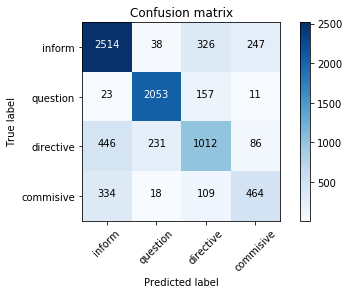

In [45]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.80448    0.01216    0.10432    0.07904   ]
 [0.01024955 0.91488414 0.06996435 0.00490196]
 [0.25126761 0.13014085 0.57014085 0.0484507 ]
 [0.36108108 0.01945946 0.11783784 0.50162162]]


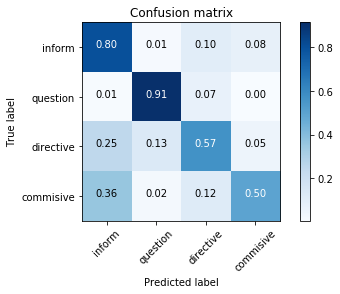

In [46]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [47]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [48]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [49]:
correctPerClass

{0: 2514, 1: 2053, 2: 1012, 3: 464}

In [50]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

Accuracy for class  0  : 0.80448
Accuracy for class  1  : 0.9148841354723708
Accuracy for class  2  : 0.5701408450704225
Accuracy for class  3  : 0.5016216216216216


# Saving the transition params